In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import communities
import ast
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from torch_geometric.data import DataLoader
import copy
import random
from sklearn.metrics import r2_score
device = torch.device("cpu")
print(torch.backends.mps.is_available())

False


In [2]:
from utils import *
from sklearn.model_selection import train_test_split
import pickle

In [8]:
#%% Data

df = pd.read_csv('final_data_2024_01_19.csv')
df = df.drop(columns=["Issuer"])

df

,CatContractId,Cedent,Underwriter,Amount,SPRating,IssueDate,MaturityDate,ExposureTerm,SpreadPremiumtoLIBOR,ExpectedLoss,...,ProbabilityofExhaust,ExpectedExcessReturn,ConditionalExpectedLoss,IssueYear,IssueMon,Perils,Country,State_Province,TriggerType,RiskModeler
0,CATCON_001,USFG,['Goldman Sachs'],24.3,UNKNOWN,3/1/99,2/1/00,12,0.0400,0.0042,...,0.0042,0.0364,0.3652,1999,3,"['hurricane', 'earthquake']",['U.S.'],['Not Specified'],Indemnity,UNKNOWN
1,CATCON_002,USFG,['E.W. Blanch'],20.0,UNKNOWN,3/1/99,2/1/00,12,0.0825,0.0284,...,0.115,0.0552,0.541,1999,3,"['hurricane', 'earthquake']",['U.S.'],['Not Specified'],Indemnity,UNKNOWN
2,CATCON_003,Kemper,['AON'],80.0,BB+,4/1/99,4/1/02,37,0.0369,0.005,...,0.0044,0.0324,0.8621,1999,4,['earthquake'],['U.S.'],['Not Specified'],Indemnity,AIR
3,CATCON_004,Kemper,['AON'],20.0,UNKNOWN,4/1/99,4/1/02,37,0.0190,0.006,...,0.0058,0.0411,0.968,1999,4,['earthquake'],['U.S.'],['Not Specified'],Indemnity,AIR
4,CATCON_005,Sorema,['Merrill Lynch'],17.0,UNKNOWN,4/1/99,4/1/02,36,0.0450,0.0063,...,0.0045,0.0393,0.75,1999,4,"['typhoon', 'windstorm', 'earthquake']","['Japan', 'Europe']",['Not Specified'],Indemnity,RMS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,CATCON_799,Sompo Nipponkoa,['AON'],200.0,NR,3/1/21,4/1/25,47,0.0400,0.0117,...,0.0116,0.0289,0.68,2021,3,"['typhoon', 'flood', 'earthquake']","['U.S.', 'Japan']",['Not Specified'],Indemnity,AIR
799,CATCON_800,Palomar Specialty Ins.,"['Guy Carpenter', 'Tiger Capital Markets']",200.0,NR,3/1/21,6/1/24,38,0.0400,0.0187,...,0.015,0.0219,0.827,2021,3,['earthquake'],['U.S.'],['Not Specified'],Indemnity,RMS
800,CATCON_801,Palomar Specialty Ins.,"['Guy Carpenter', 'Tiger Capital Markets']",200.0,NR,3/1/21,6/1/24,38,0.0525,0.0298,...,0.0226,0.0234,0.782,2021,3,['earthquake'],['U.S.'],['Not Specified'],Indemnity,RMS
801,CATCON_802,CA EQ Authority,"['AON', 'Swiss Re']",215.0,NR,3/1/21,12/1/24,44,0.0625,0.0374,...,0.0195,0.0260,0.917,2021,3,['earthquake'],['U.S.'],['California'],Indemnity,EQECAT


In [9]:
for col in ['Cedent','SPRating','Underwriter','Perils','Country','State_Province','TriggerType']:
    df[col] = df[col].apply(convert_to_list)
    
    
for col in ['Cedent','SPRating','Underwriter','Perils','Country','State_Province','TriggerType']:
    df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [x])
    
df

,CatContractId,Cedent,Underwriter,Amount,SPRating,IssueDate,MaturityDate,ExposureTerm,SpreadPremiumtoLIBOR,ExpectedLoss,...,ProbabilityofExhaust,ExpectedExcessReturn,ConditionalExpectedLoss,IssueYear,IssueMon,Perils,Country,State_Province,TriggerType,RiskModeler
0,CATCON_001,[USFG],[Goldman Sachs],24.3,[UNKNOWN],3/1/99,2/1/00,12,0.0400,0.0042,...,0.0042,0.0364,0.3652,1999,3,"[hurricane, earthquake]",[U.S.],[Not Specified],[Indemnity],UNKNOWN
1,CATCON_002,[USFG],[E.W. Blanch],20.0,[UNKNOWN],3/1/99,2/1/00,12,0.0825,0.0284,...,0.115,0.0552,0.541,1999,3,"[hurricane, earthquake]",[U.S.],[Not Specified],[Indemnity],UNKNOWN
2,CATCON_003,[Kemper],[AON],80.0,[BB+],4/1/99,4/1/02,37,0.0369,0.005,...,0.0044,0.0324,0.8621,1999,4,[earthquake],[U.S.],[Not Specified],[Indemnity],AIR
3,CATCON_004,[Kemper],[AON],20.0,[UNKNOWN],4/1/99,4/1/02,37,0.0190,0.006,...,0.0058,0.0411,0.968,1999,4,[earthquake],[U.S.],[Not Specified],[Indemnity],AIR
4,CATCON_005,[Sorema],[Merrill Lynch],17.0,[UNKNOWN],4/1/99,4/1/02,36,0.0450,0.0063,...,0.0045,0.0393,0.75,1999,4,"[typhoon, windstorm, earthquake]","[Japan, Europe]",[Not Specified],[Indemnity],RMS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,CATCON_799,[Sompo Nipponkoa],[AON],200.0,[NR],3/1/21,4/1/25,47,0.0400,0.0117,...,0.0116,0.0289,0.68,2021,3,"[typhoon, flood, earthquake]","[U.S., Japan]",[Not Specified],[Indemnity],AIR
799,CATCON_800,[Palomar Specialty Ins.],"[Guy Carpenter, Tiger Capital Markets]",200.0,[NR],3/1/21,6/1/24,38,0.0400,0.0187,...,0.015,0.0219,0.827,2021,3,[earthquake],[U.S.],[Not Specified],[Indemnity],RMS
800,CATCON_801,[Palomar Specialty Ins.],"[Guy Carpenter, Tiger Capital Markets]",200.0,[NR],3/1/21,6/1/24,38,0.0525,0.0298,...,0.0226,0.0234,0.782,2021,3,[earthquake],[U.S.],[Not Specified],[Indemnity],RMS
801,CATCON_802,[CA EQ Authority],"[AON, Swiss Re]",215.0,[NR],3/1/21,12/1/24,44,0.0625,0.0374,...,0.0195,0.0260,0.917,2021,3,[earthquake],[U.S.],[California],[Indemnity],EQECAT


In [10]:
percentage_columns = ['ExpectedLoss', 'Probabilityof1stLoss', 'ProbabilityofExhaust','ConditionalExpectedLoss']  

for column in percentage_columns:
    df[column] = df[column].str.replace('%', '').astype(float) / 100

df = df.sort_values(by=['IssueYear', 'IssueMon'])
df = df.drop(['IssueYear', 'IssueMon'], axis=1)

df['IssueYear'] = pd.to_datetime(df['IssueDate']).dt.year
df['IssueMonth'] = pd.to_datetime(df['IssueDate']).dt.month
df['MaturityYear'] = pd.to_datetime(df['MaturityDate']).dt.year
df['MaturityMonth'] = pd.to_datetime(df['MaturityDate']).dt.month

df.drop(['IssueDate', 'MaturityDate', 'MaturityMonth', 'MaturityYear'], axis=1, inplace=True)

df

C:\Users\u0130739\AppData\Local\Temp\ipykernel_2040\443179222.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['IssueYear'] = pd.to_datetime(df['IssueDate']).dt.year
C:\Users\u0130739\AppData\Local\Temp\ipykernel_2040\443179222.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['IssueMonth'] = pd.to_datetime(df['IssueDate']).dt.month
C:\Users\u0130739\AppData\Local\Temp\ipykernel_2040\443179222.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['MaturityYear'] = pd.to_datetime(df['MaturityDate']).dt.year
C:\Users\u0130739\AppData\Local\Temp\ipykernel_2040\44

,CatContractId,Cedent,Underwriter,Amount,SPRating,ExposureTerm,SpreadPremiumtoLIBOR,ExpectedLoss,Probabilityof1stLoss,ProbabilityofExhaust,ExpectedExcessReturn,ConditionalExpectedLoss,Perils,Country,State_Province,TriggerType,RiskModeler,IssueYear,IssueMonth
0,CATCON_001,[USFG],[Goldman Sachs],24.3,[UNKNOWN],12,0.0400,0.000042,0.000115,0.000042,0.0364,0.003652,"[hurricane, earthquake]",[U.S.],[Not Specified],[Indemnity],UNKNOWN,1999,3
1,CATCON_002,[USFG],[E.W. Blanch],20.0,[UNKNOWN],12,0.0825,0.000284,0.000525,0.001150,0.0552,0.005410,"[hurricane, earthquake]",[U.S.],[Not Specified],[Indemnity],UNKNOWN,1999,3
2,CATCON_003,[Kemper],[AON],80.0,[BB+],37,0.0369,0.000050,0.000058,0.000044,0.0324,0.008621,[earthquake],[U.S.],[Not Specified],[Indemnity],AIR,1999,4
3,CATCON_004,[Kemper],[AON],20.0,[UNKNOWN],37,0.0190,0.000060,0.000082,0.000058,0.0411,0.009680,[earthquake],[U.S.],[Not Specified],[Indemnity],AIR,1999,4
4,CATCON_005,[Sorema],[Merrill Lynch],17.0,[UNKNOWN],36,0.0450,0.000063,0.000084,0.000045,0.0393,0.007500,"[typhoon, windstorm, earthquake]","[Japan, Europe]",[Not Specified],[Indemnity],RMS,1999,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,CATCON_799,[Sompo Nipponkoa],[AON],200.0,[NR],47,0.0400,0.000117,0.000172,0.000116,0.0289,0.006800,"[typhoon, flood, earthquake]","[U.S., Japan]",[Not Specified],[Indemnity],AIR,2021,3
799,CATCON_800,[Palomar Specialty Ins.],"[Guy Carpenter, Tiger Capital Markets]",200.0,[NR],38,0.0400,0.000187,0.000226,0.000150,0.0219,0.008270,[earthquake],[U.S.],[Not Specified],[Indemnity],RMS,2021,3
800,CATCON_801,[Palomar Specialty Ins.],"[Guy Carpenter, Tiger Capital Markets]",200.0,[NR],38,0.0525,0.000298,0.000381,0.000226,0.0234,0.007820,[earthquake],[U.S.],[Not Specified],[Indemnity],RMS,2021,3
801,CATCON_802,[CA EQ Authority],"[AON, Swiss Re]",215.0,[NR],44,0.0625,0.000374,0.000408,0.000195,0.0260,0.009170,[earthquake],[U.S.],[California],[Indemnity],EQECAT,2021,3


In [11]:
df = df.explode('Cedent').explode('SPRating').explode('Underwriter').explode(
    'Perils').explode('Country').explode('State_Province').explode('TriggerType')

# drop NaNs
df = df.dropna()

df

,CatContractId,Cedent,Underwriter,Amount,SPRating,ExposureTerm,SpreadPremiumtoLIBOR,ExpectedLoss,Probabilityof1stLoss,ProbabilityofExhaust,ExpectedExcessReturn,ConditionalExpectedLoss,Perils,Country,State_Province,TriggerType,RiskModeler,IssueYear,IssueMonth
0,CATCON_001,USFG,Goldman Sachs,24.3,UNKNOWN,12,0.0400,0.000042,0.000115,0.000042,0.0364,0.003652,hurricane,U.S.,Not Specified,Indemnity,UNKNOWN,1999,3
0,CATCON_001,USFG,Goldman Sachs,24.3,UNKNOWN,12,0.0400,0.000042,0.000115,0.000042,0.0364,0.003652,earthquake,U.S.,Not Specified,Indemnity,UNKNOWN,1999,3
1,CATCON_002,USFG,E.W. Blanch,20.0,UNKNOWN,12,0.0825,0.000284,0.000525,0.001150,0.0552,0.005410,hurricane,U.S.,Not Specified,Indemnity,UNKNOWN,1999,3
1,CATCON_002,USFG,E.W. Blanch,20.0,UNKNOWN,12,0.0825,0.000284,0.000525,0.001150,0.0552,0.005410,earthquake,U.S.,Not Specified,Indemnity,UNKNOWN,1999,3
2,CATCON_003,Kemper,AON,80.0,BB+,37,0.0369,0.000050,0.000058,0.000044,0.0324,0.008621,earthquake,U.S.,Not Specified,Indemnity,AIR,1999,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,CATCON_801,Palomar Specialty Ins.,Guy Carpenter,200.0,NR,38,0.0525,0.000298,0.000381,0.000226,0.0234,0.007820,earthquake,U.S.,Not Specified,Indemnity,RMS,2021,3
800,CATCON_801,Palomar Specialty Ins.,Tiger Capital Markets,200.0,NR,38,0.0525,0.000298,0.000381,0.000226,0.0234,0.007820,earthquake,U.S.,Not Specified,Indemnity,RMS,2021,3
801,CATCON_802,CA EQ Authority,AON,215.0,NR,44,0.0625,0.000374,0.000408,0.000195,0.0260,0.009170,earthquake,U.S.,California,Indemnity,EQECAT,2021,3
801,CATCON_802,CA EQ Authority,Swiss Re,215.0,NR,44,0.0625,0.000374,0.000408,0.000195,0.0260,0.009170,earthquake,U.S.,California,Indemnity,EQECAT,2021,3


In [12]:
# Replace "Not Specified" with "UNKNOWN" in all columns
df.replace("Not Specified", "UNKNOWN", inplace=True)

df['Country'].replace("Madrid", "Spain", inplace = True)

# Convert "UNKNOWN" within each category to "UNKNOWN_name of that category"
columns_to_process = ['Cedent','SPRating','Underwriter','Perils','Country','State_Province','TriggerType', 'RiskModeler']

for column in columns_to_process:
    unknown_mapping = {'UNKNOWN': f'UNKNOWN_{column}'}
    df[column] = df[column].replace(unknown_mapping)

# Display the updated DataFrame
df

,CatContractId,Cedent,Underwriter,Amount,SPRating,ExposureTerm,SpreadPremiumtoLIBOR,ExpectedLoss,Probabilityof1stLoss,ProbabilityofExhaust,ExpectedExcessReturn,ConditionalExpectedLoss,Perils,Country,State_Province,TriggerType,RiskModeler,IssueYear,IssueMonth
0,CATCON_001,USFG,Goldman Sachs,24.3,UNKNOWN_SPRating,12,0.0400,0.000042,0.000115,0.000042,0.0364,0.003652,hurricane,U.S.,UNKNOWN_State_Province,Indemnity,UNKNOWN_RiskModeler,1999,3
0,CATCON_001,USFG,Goldman Sachs,24.3,UNKNOWN_SPRating,12,0.0400,0.000042,0.000115,0.000042,0.0364,0.003652,earthquake,U.S.,UNKNOWN_State_Province,Indemnity,UNKNOWN_RiskModeler,1999,3
1,CATCON_002,USFG,E.W. Blanch,20.0,UNKNOWN_SPRating,12,0.0825,0.000284,0.000525,0.001150,0.0552,0.005410,hurricane,U.S.,UNKNOWN_State_Province,Indemnity,UNKNOWN_RiskModeler,1999,3
1,CATCON_002,USFG,E.W. Blanch,20.0,UNKNOWN_SPRating,12,0.0825,0.000284,0.000525,0.001150,0.0552,0.005410,earthquake,U.S.,UNKNOWN_State_Province,Indemnity,UNKNOWN_RiskModeler,1999,3
2,CATCON_003,Kemper,AON,80.0,BB+,37,0.0369,0.000050,0.000058,0.000044,0.0324,0.008621,earthquake,U.S.,UNKNOWN_State_Province,Indemnity,AIR,1999,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,CATCON_801,Palomar Specialty Ins.,Guy Carpenter,200.0,NR,38,0.0525,0.000298,0.000381,0.000226,0.0234,0.007820,earthquake,U.S.,UNKNOWN_State_Province,Indemnity,RMS,2021,3
800,CATCON_801,Palomar Specialty Ins.,Tiger Capital Markets,200.0,NR,38,0.0525,0.000298,0.000381,0.000226,0.0234,0.007820,earthquake,U.S.,UNKNOWN_State_Province,Indemnity,RMS,2021,3
801,CATCON_802,CA EQ Authority,AON,215.0,NR,44,0.0625,0.000374,0.000408,0.000195,0.0260,0.009170,earthquake,U.S.,California,Indemnity,EQECAT,2021,3
801,CATCON_802,CA EQ Authority,Swiss Re,215.0,NR,44,0.0625,0.000374,0.000408,0.000195,0.0260,0.009170,earthquake,U.S.,California,Indemnity,EQECAT,2021,3


In [13]:
# Define the columns you want to consider in the graph
selected_columns =['CatContractId', 'Cedent', 'Underwriter','Perils', 'Country', 'State_Province', 'RiskModeler']

# Create a graph
G_new = nx.Graph()

# Add nodes to the graph based on unique values in selected columns
for column in selected_columns:
    unique_values = df[column].unique()
    for value in unique_values:
        G_new.add_node(value, node_type=column)

# Add edges between CATID and other nodes for each row
for _, row in df.iterrows():
    cat_id = row['CatContractId']
    for column in selected_columns[1:]:
        value = row[column]
        G_new.add_edge(cat_id, value, edge_type=column)

        # Add pairwise edges between nodes within the same row
        row_values = row[selected_columns[1:]].tolist()
        for i in range(len(row_values) - 1):
            G_new.add_edge(row_values[i], row_values[i + 1], edge_type ='entity_interaction' )

In [14]:
attr = ['Amount', 'ExposureTerm', 'ExpectedLoss', 'Probabilityof1stLoss', 'ProbabilityofExhaust',
        'ExpectedExcessReturn', 'ConditionalExpectedLoss', 'TriggerType', 'SPRating']

# Add attributes specified in 'attr' to 'CatContractId' nodes
for _, row in df.iterrows():
    cat_id = row['CatContractId']
    if G_new.nodes[cat_id]['node_type'] == 'CatContractId':
        for attr_name in attr:
            G_new.nodes[cat_id][attr_name] = row[attr_name]


In [15]:
# Compute centrality measures
betweenness_centrality = nx.betweenness_centrality(G_new)
degree_centrality = nx.degree_centrality(G_new)
eigenvector_centrality = nx.eigenvector_centrality(G_new)
closeness_centrality = nx.closeness_centrality(G_new)
katz_centrality = nx.katz_centrality_numpy(G_new)

# Add centrality measures as attributes to the nodes
for node in G_new.nodes():
    G_new.nodes[node]['betweenness_centrality'] = betweenness_centrality[node]
    G_new.nodes[node]['degree_centrality'] = degree_centrality[node]
    G_new.nodes[node]['eigenvector_centrality'] = eigenvector_centrality[node]
    G_new.nodes[node]['closeness_centrality'] = closeness_centrality[node]
    G_new.nodes[node]['katz_centrality'] = katz_centrality[node]

In [16]:
node_id='CATCON_001'
node_attributes = G_new.nodes[node_id]
print(f"Attributes of Node {node_id}: {node_attributes}")

Attributes of Node CATCON_001: {'node_type': 'CatContractId', 'Amount': 24.3, 'ExposureTerm': 12, 'ExpectedLoss': 4.2e-05, 'Probabilityof1stLoss': 0.000115, 'ProbabilityofExhaust': 4.2e-05, 'ExpectedExcessReturn': 0.0364, 'ConditionalExpectedLoss': 0.0036520000000000003, 'TriggerType': 'Indemnity', 'SPRating': 'UNKNOWN_SPRating', 'betweenness_centrality': 0.0003907647772359861, 'degree_centrality': 0.006416131989000917, 'eigenvector_centrality': 0.022007905678488756, 'closeness_centrality': 0.48061674008810573, 'katz_centrality': -0.0017219220259012723}


In [17]:
node_id='Goldman Sachs'
node_attributes = G_new.nodes[node_id]
print(f"Attributes of Node {node_id}: {node_attributes}")

Attributes of Node Goldman Sachs: {'node_type': 'Underwriter', 'betweenness_centrality': 0.03926024790505597, 'degree_centrality': 0.2392300641613199, 'eigenvector_centrality': 0.12445121959091258, 'closeness_centrality': 0.5382338431179082, 'katz_centrality': 0.12843441388927979}


Best Modularity: 0.000707038956955002
Best Communities: ({'CATCON_661', 'CATCON_213', 'CATCON_764', 'CATCON_373', 'CATCON_802', 'CATCON_301', 'CATCON_228', 'mortality', 'UNKNOWN_RiskModeler', 'CATCON_274', 'CATCON_332', 'CATCON_059', 'CATCON_303', 'temperature', 'Aspen Ins. Holdings', 'CATCON_224', 'CATCON_402', 'brushfire', 'CATCON_326', 'Andorra', 'CATCON_597', 'CATCON_686', 'CATCON_148', 'CATCON_435', 'CATCON_026', 'CATCON_471', 'CATCON_276', 'CATCON_265', 'CATCON_391', 'CATCON_505', 'CATCON_085', 'CATCON_222', 'CATCON_453', 'CATCON_658', 'United  PC', 'Sorema', 'FONDEN', 'CATCON_525', 'CATCON_579', 'CATCON_734', 'CATCON_721', 'CATCON_209', 'France', 'CATCON_039', 'CATCON_506', 'CATCON_692', 'CATCON_393', 'CATCON_474', 'CATCON_289', 'CATCON_238', 'State Farm', 'CATCON_077', 'CATCON_184', 'CATCON_304', 'CATCON_798', 'CATCON_142', 'CATCON_254', 'Great American Ins.', 'CATCON_333', 'CATCON_249', 'Hannover Re', 'Renaissance Re', 'CATCON_560', 'Illinois', 'CATCON_376', 'CATCON_056', 'JLT

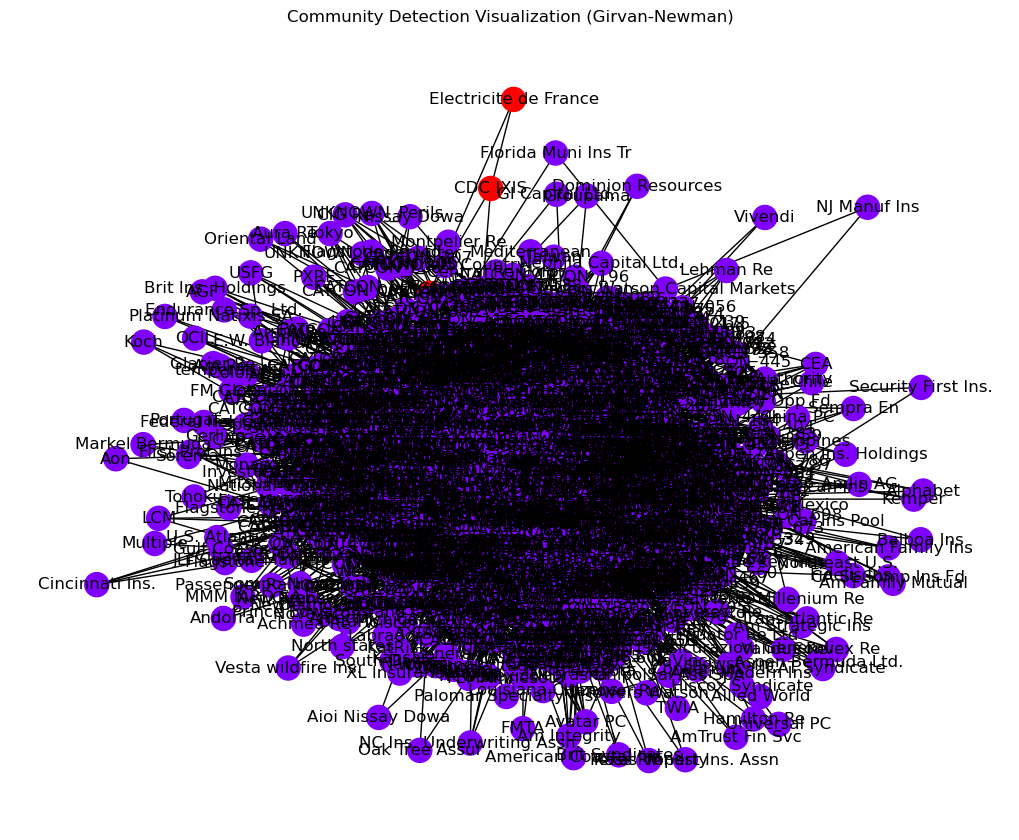

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman

# Perform community detection using Girvan-Newman
communities = girvan_newman(G_new)

# Extract the communities from the generator
best_communities = next(communities)

# Calculate modularity for the detected communities
best_modularity = nx.algorithms.community.quality.modularity(G_new, [set(c) for c in best_communities])

# Print the best results
print("Best Modularity:", best_modularity)
print("Best Communities:", best_communities)

# Visualize the communities
node_community_map = {node: i for i, community in enumerate(best_communities) for node in community}

pos = nx.spring_layout(G_new)  # You can use a different layout algorithm
colors = [node_community_map[node] for node in G_new.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G_new, pos, node_color=colors, with_labels=True, cmap=plt.cm.rainbow)
plt.title('Community Detection Visualization (Girvan-Newman)')
plt.show()

In [19]:
# Print the number of communities
num_communities = len(best_communities)
print("Number of Communities:", num_communities)

Number of Communities: 2


Best Modularity: 0.35990306778531994
Best Resolution: 1.0
Best Communities: [{'CATCON_195', 'CATCON_200', 'CATCON_247', 'CATCON_185', 'CATCON_280', 'UNKNOWN_RiskModeler', 'Peru', 'Arrow Re', 'Aspen Ins. Holdings', 'CATCON_244', 'brushfire', 'CATCON_197', 'CATCON_686', 'CATCON_634', 'CATCON_181', 'Citibank', 'CATCON_222', 'CATCON_218', 'CATCON_311', 'CATCON_138', 'Portugal', 'CATCON_021', 'CATCON_199', 'CATCON_220', 'State Farm', 'Turkey', 'CATCON_184', 'CATCON_203', 'CATCON_130', 'CATCON_249', 'CATCON_234', 'CATCON_633', 'CATCON_360', 'CATCON_137', 'CATCON_159', 'CATCON_235', 'CATCON_166', 'American Re', 'CATCON_287', 'CATCON_389', 'CATCON_118', 'CATCON_183', 'Nephila Capital Ltd.', 'Chubb Group', 'CATCON_215', 'CATCON_288', 'CATCON_127', 'CATCON_217', 'CATCON_135', 'CATCON_223', 'CATCON_632', 'CATCON_423', 'CATCON_179', 'CATCON_001', 'CATCON_225', 'tornado', 'CATCON_325', 'CATCON_519', 'Am Re', 'CATCON_193', 'CATCON_128', 'CATCON_419', 'Spain', 'Mediterranean', 'CATCON_286', 'CATCON_5

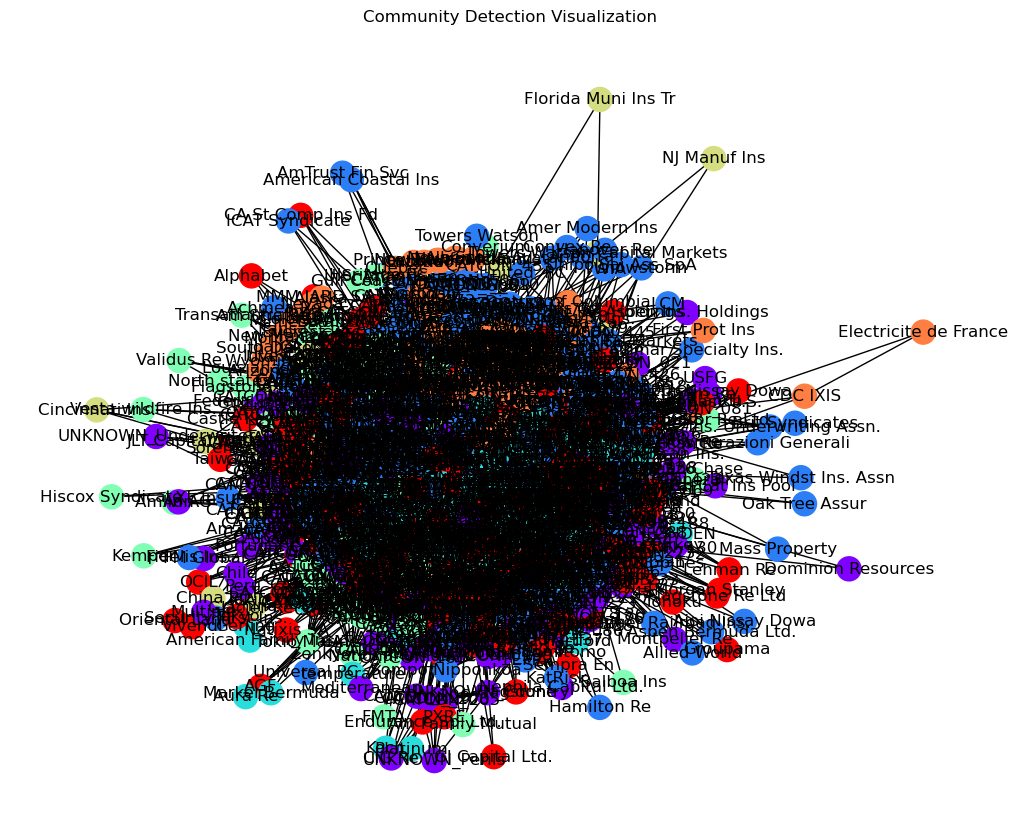

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity



# Parameter tuning for Louvain
resolution_values = [0.1, 0.5, 1.0, 1.5]

# Perform grid search
best_modularity = float('-inf')
best_resolution = None
best_communities = None

for resolution in resolution_values:
    communities = louvain_communities(G_new, weight='weight', resolution=resolution, seed=10)
    current_modularity = modularity(G_new, communities)
    
    if current_modularity > best_modularity:
        best_modularity = current_modularity
        best_resolution = resolution
        best_communities = communities

# Print the best results
print("Best Modularity:", best_modularity)
print("Best Resolution:", best_resolution)
print("Best Communities:", best_communities)

# Visualize the communities
communities_list = [list(community) for community in best_communities]
node_community_map = {node: i for i, community in enumerate(communities_list) for node in community}

pos = nx.spring_layout(G_new)  # You can use a different layout algorithm
colors = [node_community_map[node] for node in G_new.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G_new, pos, node_color=colors, with_labels=True, cmap=plt.cm.rainbow)
plt.title('Community Detection Visualization')
plt.show()

In [21]:
# Print the number of communities
num_communities = len(best_communities)
print("Number of Communities:", num_communities)

Number of Communities: 7


In [23]:
# import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from networkx.algorithms.community import (greedy_modularity_communities,
                                           k_clique_communities,
                                           louvain_communities)

from sklearn.metrics.cluster import adjusted_rand_score

In [24]:
g1_gm = greedy_modularity_communities(G_new, weight='weight')
g1_louvain = louvain_communities(G_new, weight='weight')

In [25]:
def community_size_distribution(communities, ax=None):
    x = [len(c) for c in communities]
    if ax is None:
        return plt.hist(x, bins=20)
    return ax.hist(x, bins=20)

Text(0.5, 0, 'Community Size')

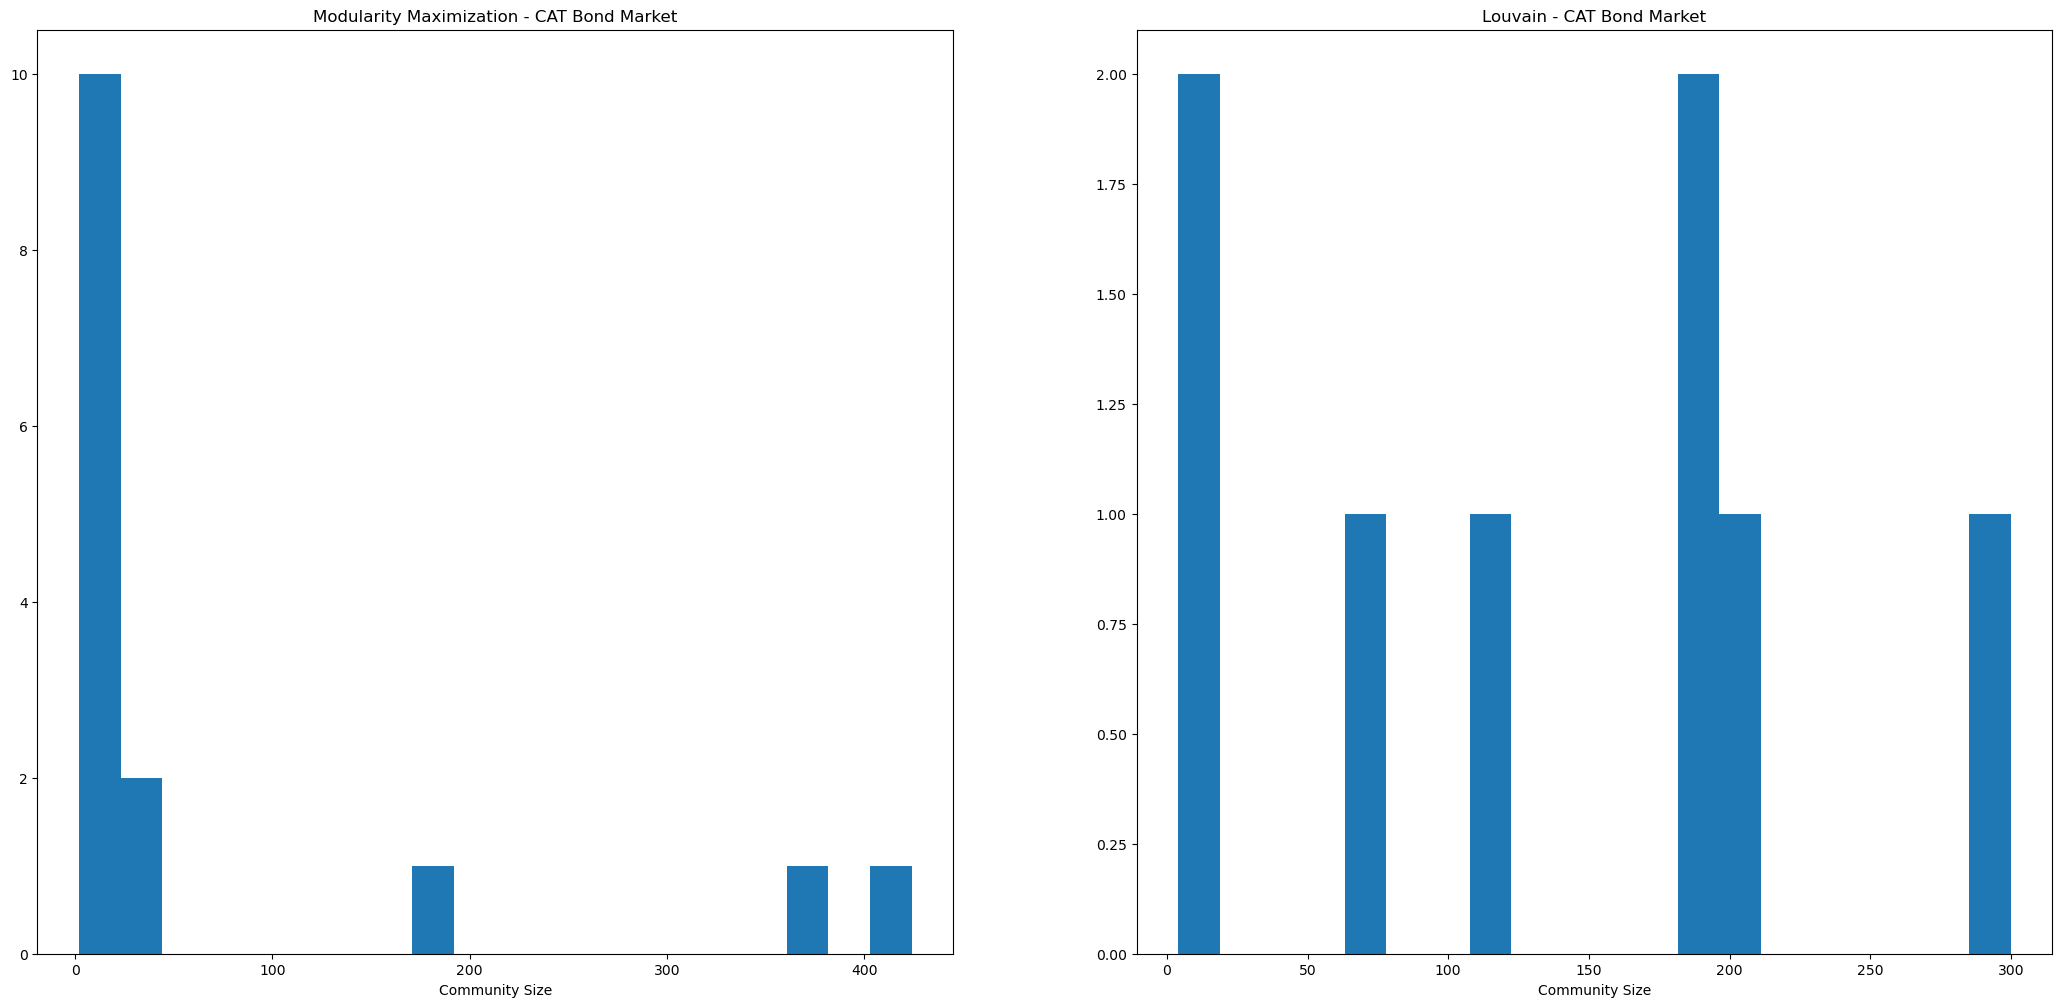

In [26]:
# Community size distribution 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(26, 12))
community_size_distribution(g1_gm, axs[0])
community_size_distribution(g1_louvain, axs[1])

axs[0].set_title("Modularity Maximization - CAT Bond Market")
axs[0].set_xlabel("Community Size")

axs[1].set_title("Louvain - CAT Bond Market")
axs[1].set_xlabel("Community Size")

C:\Users\u0130739\AppData\Local\Temp\ipykernel_2040\3616723473.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


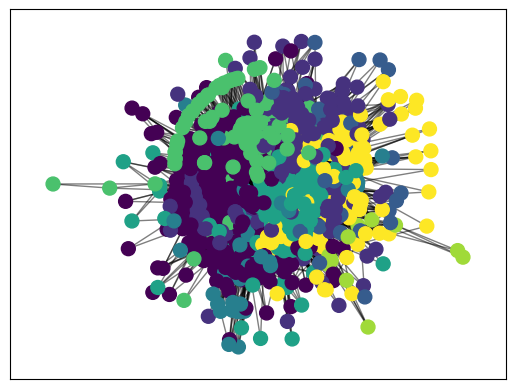

In [27]:
## To genrate the same result as Gephi for the community detection 


import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# retrun partition as a dict
partition = community_louvain.best_partition(G_new)
# visualization
pos = nx.spring_layout(G_new)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G_new, pos, partition.keys(), node_size=100,cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G_new, pos, alpha=0.5)
plt.show()

In [28]:
# Print the number of communities
num_communities = len(set(partition.values()))
print("Number of Communities:", num_communities)

Number of Communities: 8
